In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sceptr
import tidytcells as tt
from scipy import optimize
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.spatial.distance import pdist
import Levenshtein 
import os
import scipy.stats as stats
import seaborn as sns
import matplotlib.patches as mpatches

In [2]:
# load data
folder = 'prolif_nt'
files = [f for f in os.listdir(folder) if f[0][0] != '.']
out_beta = []
out_alpha = []
beta_list = []
alpha_list = []
for i, fr in enumerate(files):
    a = fr.split('_')[2]
    b = a.split('.')[0]
    df = pd.read_csv(folder + '/' + fr)
    cols = df.columns.tolist()
    if i == 0:
        days = [int(x.split(' ')[1]) for x in cols[:len(cols)-1]]
    out_t = np.zeros([len(df['key'].to_list()),len(cols)-1]);
    for j, dy in enumerate(cols[:len(cols)-1]):
        temp = np.array(df[dy].to_list())
        out_t[:,j] = temp
    key = df['key'].to_list()
    if b == 'beta':
        beta_list.append(fr.split('_')[1])
        Jgene_t = [x.split('_')[3] for x in key]
        Vgene_t = [x.split('_')[2] for x in key]
        CDR3_t = [x.split('_')[1] for x in key]
        nt_t = [x.split('_')[0] for x in key]
        temp = []
        for k, x in enumerate(list(out_t)):
            temp.append([list(x),(CDR3_t[k],Vgene_t[k],Jgene_t[k],nt_t[k])])
        out_beta.append(temp);
    if b == 'alpha':
        alpha_list.append(fr.split('_')[1])
        Jgene_t = [x.split('_')[3] for x in key]
        Vgene_t = [x.split('_')[2] for x in key]
        CDR3_t = [x.split('_')[1] for x in key]
        nt_t = [x.split('_')[0] for x in key]
        temp = []
        for k, x in enumerate(list(out_t)):
            temp.append([list(x),(CDR3_t[k],Vgene_t[k],Jgene_t[k],nt_t[k])])
        out_alpha.append(temp);
# alpha/beta_list: patient ID, out_alpha/beta: [time series, (CDR3_aa, Vgene, Jgene, CDR3_nt)] & days: sample days

In [3]:
# reorder lists so they are paired
thr = 20

total_list = []
total_list.extend(alpha_list)
total_list.extend(beta_list)
total_list = list(np.sort([int(x) for x in list(set(total_list))]))
total_list = [str(x) for x in total_list]

out_alpha_sorted = []
for x in total_list:
    for i, y in enumerate(alpha_list):
        if x == y:
            out_alpha_sorted.append(out_alpha[i])
out_beta_sorted = []
for x in total_list:
    for i, y in enumerate(beta_list):
        if x == y:
            out_beta_sorted.append(out_beta[i])
La = [len(x) for x in out_alpha_sorted]
Lb = [len(x) for x in out_beta_sorted]

out_beta_sorted = [x for i, x in enumerate(out_beta_sorted) if Lb[i] >= thr and La[i] >= thr]
out_alpha_sorted = [x for i, x in enumerate(out_alpha_sorted) if La[i] >= thr and Lb[i] >= thr]
total_list_sorted = [x for i, x in enumerate(total_list) if La[i] >= thr and Lb[i] >= thr]
N_seqs = [(La[i], Lb[i]) for i in range(len(La)) if La[i] >= thr and Lb[i] >= thr]

In [4]:
# fit function
def func(x, rp, rd, ds, A):
    return np.log10(2/(np.exp(-(x-ds)/rp)+np.exp((x-ds)/rd))) + A
def func2(x, rp, rd):
    return np.log10(2/(np.exp(-x*rp)+np.exp(x*rd)))

/var/folders/zm/c02xmwfx58l3xfx_hgwyrdgw0000gn/T/ipykernel_85944/3632973226.py:115: RuntimeWarning: divide by zero encountered in log10
  plt.plot(x_in - d_star, np.log10(y_in1) - Amax,qrplt + '.', markersize=2)
/var/folders/zm/c02xmwfx58l3xfx_hgwyrdgw0000gn/T/ipykernel_85944/3632973226.py:72: RuntimeWarning: divide by zero encountered in log10
  y_end = np.log10(y[-1])


alpha max freq: 1 in 175
beta max freq: 1 in 216


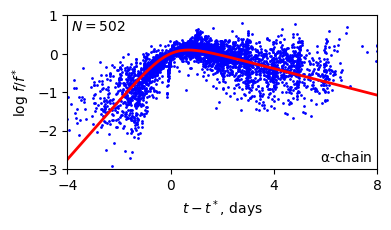

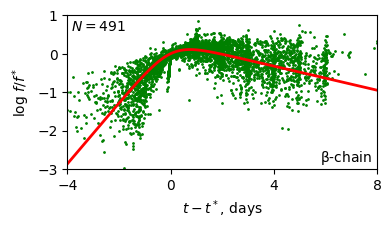

In [5]:
# choice to analyze
chain_type = 'alpha'

fits = []
full_out = []

Fend_all = []
R_all = []


for chain_type in ['alpha','beta']:
######
    if chain_type == 'alpha':
        chain_set = out_alpha_sorted
        qrplt = 'b'
        xDelt = -0.15
        lab = r'$\mathrm{\alpha}$'
    if chain_type == 'beta':
        chain_set = out_beta_sorted
        qrplt = 'g'
        xDelt = 0.15
        lab = r'$\mathrm{\beta}$'
    # fit trajectories
    ###########################
    plt.figure(figsize=(4,2))
    plt.ylim([-3,1])
    plt.xlim([-4,8])
    plt.xticks([-4,0,4,8])
    xf = np.linspace(0,30,1000)
    plt.xlabel(r'$t - t^*$, days')
    plt.ylabel(r'log $f/f^*$')
    ###########################
    rp_t = []
    rd_t = []
    Amax_t = []
    d_star_t = []
    out_pair = []
    cable = []
    ###########################
    rp_indiv = []
    rd_indiv = []
    d_star_indiv = []
    Amax_indiv = []
    fit_flag = []
    
    n_cnt = 0
    
    L_chain_sel = []
    xrs_all = []
    yrs_all = []
    
    C_max = []

    F_indiv = []
    R_indiv = []
    for ijk, temp in enumerate(chain_set):
        pair_temp = []
        rp_indiv_t = []
        rd_indiv_t = []
        d_star_indiv_t = []
        Amax_indiv_t = []
        fit_flag_temp = np.zeros(len(temp))
    
        n_chain = 0
    
        C_max_temp = []
        F_temp = []
        R_temp = []
        for iqq, z in enumerate(temp):
            y = z[0]
            
            y_end = np.log10(y[-1])
            
            x_in = days[3:10]
            y_in1 = y[3:10]
    
            x22 = [x_in[ik] for ik, q in enumerate(y_in1) if q > 0]
            y22 = np.log10([q for q in y_in1 if q > 0])
    
            if len(x22) >= 5 and max(y22) - min(y22) > 0.5:
                popt, pcov = optimize.curve_fit(func, x22 , y22, 
                                                p0 = (8/24,60/24,10,-2), bounds = ((1/24,5/24,6,-6), (30/24,1000/24,14,0)))
                
                lam = np.linalg.cond(pcov)
                yf = func(xf, popt[0],popt[1],popt[2],popt[3])
                Amax = popt[3]; d_star = popt[2]
                if popt[0] > 2/24 and popt[1] < 750/24 and popt[2] > 7:# and popt[2] < 13.7
                    C_max_temp.append(np.max(y_in1))
                    n_cnt += 1
                    n_chain += 1
                    fit_flag_temp[iqq] = 1
                    rp_indiv_t.append(popt[0])
                    rd_indiv_t.append(popt[1])
                    rp_t.append(popt[0])
                    rd_t.append(popt[1])
                    d_star_t.append(d_star)
                    d_star_indiv_t.append(d_star)
                    Amax_t.append(Amax)
                    Amax_indiv_t.append(Amax)
                    cable.append(ijk)
                    

                    F_temp.append(y_end - Amax)
                    R_temp.append(y_end - func(28, popt[0], popt[1], popt[2], popt[3]))
    
                    xrs_all.extend(x22 - d_star)
                    yrs_all.extend(y22 - Amax)

                    Q = list(popt)
                    Q.append(y_end - Amax)
                    Q.append(y_end - func(28, popt[0], popt[1], popt[2], popt[3]))
                    pair_temp.append([Q,z[1]])
                
                if 1:
                    plt.plot(x_in - d_star, np.log10(y_in1) - Amax,qrplt + '.', markersize=2)
        F_indiv.append(F_temp)
        R_indiv.append(R_temp)
        C_max.append(np.max(C_max_temp))
        
        L_chain_sel.append(n_chain)
            
        d_star_indiv.append(d_star_indiv_t)
        Amax_indiv.append(Amax_indiv_t)
        
        fit_flag.append(fit_flag_temp)
        out_pair.append(pair_temp)
        rp_indiv.append(rp_indiv_t)
        rd_indiv.append(rd_indiv_t)

    full_out.append(out_pair)
    Fend_all.append(F_indiv)
    R_all.append(R_indiv)
    
    fits.append([rp_indiv, rd_indiv, d_star_indiv,Amax_indiv])
    popt, pcov = optimize.curve_fit(func2, [rr for rr in xrs_all if rr > -3] , [yrs_all[irr] for irr, rr in enumerate(xrs_all) if rr > -3], 
                                                p0 = (2,0.5), bounds = ((0.001,0.001), (10,10)))
    xf2 = np.linspace(-8,8,1000)
    yf = func2(xf2, popt[0],popt[1])
    plt.plot(xf2, yf,'r',linewidth=2)
    
    plt.text(-2.8,0.6, r'$N=$' + str(n_cnt), fontsize=10, color='k', ha='center')
    plt.text(6.8,-2.8, lab + '-chain' , fontsize=10, color='k', ha='center')
    
    plt.savefig('figures/' + chain_type + '_Fig_1bc.svg') #########

    print(chain_type + ' max freq: 1 in ' + str(round(1/np.mean(C_max))))
######

alpha range: 11 - 110
beta range: 14 - 120
Patient IDs (in order): 


['634105',
 '635495',
 '635729',
 '635779',
 '637340',
 '647785',
 '666660',
 '673353',
 '674700',
 '680539']

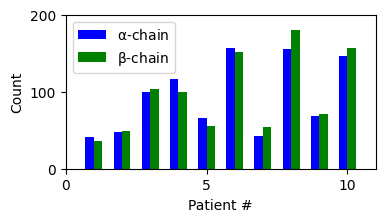

In [6]:
La = [len(x) for x in full_out[0]]
Lb = [len(x) for x in full_out[1]]

print('alpha range: ' + str(min(La)) + ' - ' + str(max(La)))
print('beta range: ' + str(min(Lb)) + ' - ' + str(max(Lb)))

plt.figure(figsize=(4,2))
plt.bar(np.array(list(range(1,len(N_seqs) + 1)))-0.15,[x[0] for x in N_seqs],width=0.3,color='b',label = r'$\mathrm{\alpha}$-chain')
plt.bar(np.array(list(range(1,len(N_seqs) + 1)))+0.15,[x[1] for x in N_seqs],width=0.3,color ='g',label = r'$\mathrm{\beta}$-chain')
plt.xlim([0,11])
plt.xticks([0,5,10])
plt.ylim(0,200)
plt.yticks([0,100,200])
plt.xlabel('Patient #');
plt.ylabel('Count');
plt.legend(fontsize='10')
plt.savefig('figures/SI_Fig_1a.svg') #########

print('Patient IDs (in order): ')
total_list_sorted

alpha T_e = 12.7 +- 1.0 hours
beta T_e = 12.3 +- 1.6 hours
alpha T_c = 79.7 +- 12.6 hours
beta T_c = 93.3 +- 26.1 hours
alpha t^* = 9.5 +- 0.3 day
beta t^* = 9.5 +- 0.4 day
alpha: f^* = -3.59619 +- 0.12661
beta: f^* = -3.6759 +- 0.11591


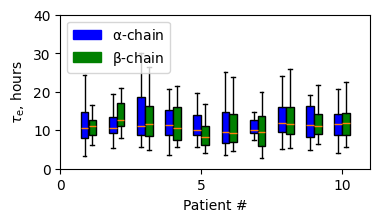

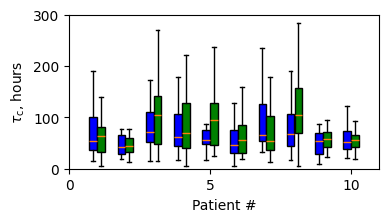

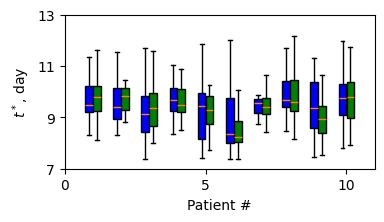

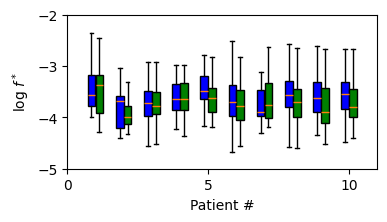

In [7]:
NID = len(total_list_sorted)
######################################################
plt.figure(figsize=(4,2))
for chain_type in ['alpha','beta']:

    if chain_type == 'alpha':
        chain_set = out_alpha_sorted
        qrplt = 'b'
        xDelt = -0.14
        lab = r'$\mathrm{\alpha}$'
        rp_indiv = fits[0][0]
    if chain_type == 'beta':
        chain_set = out_beta_sorted
        qrplt = 'g'
        xDelt = 0.14
        lab = r'$\mathrm{\beta}$'
        rp_indiv = fits[1][0]

    bplot = plt.boxplot([list(24*np.array(x)) for x in rp_indiv], showfliers=False,patch_artist=True,widths = 0.275,positions=np.array(list(range(NID))) + 1 +xDelt)
    for patch in bplot['boxes']:
        patch.set_facecolor(qrplt)

    plt.xlabel('Patient #')
    plt.ylabel(r'$\tau_\mathrm{e}$, hours')
                                 
    A1 = 24*np.mean([np.mean(x) for x in rp_indiv])
    A1 = np.round(A1*10)/10
    A2 = 24*np.std([np.mean(x) for x in rp_indiv])
    A2 = np.round(A2*10)/10
                         
    print(chain_type + ' T_e =', str(A1) , '+- ' + str(A2), 'hours')

plt.ylim([0,40])
plt.xlim([0,11])
plt.xticks([0,5,10],[0,5,10])

blue_patch = mpatches.Patch(color='b', label=r'$\mathrm{\alpha}$-chain')
green_patch = mpatches.Patch(color='g', label=r'$\mathrm{\beta}$-chain')
plt.legend(handles=[blue_patch, green_patch], loc='upper left',fontsize=10)

plt.savefig('figures/Fig_1d.svg') #######

######################################################
plt.figure(figsize=(4,2))
for chain_type in ['alpha','beta']:

    if chain_type == 'alpha':
        chain_set = out_alpha_sorted
        qrplt = 'b'
        xDelt = -0.14
        lab = r'$\mathrm{\alpha}$'
        rd_indiv = fits[0][1]
    if chain_type == 'beta':
        chain_set = out_beta_sorted
        qrplt = 'g'
        xDelt = 0.14
        lab = r'$\mathrm{\beta}$'
        rd_indiv = fits[1][1]

    bplot = plt.boxplot([list(24*np.array(x)) for x in rd_indiv], showfliers=False,patch_artist=True,widths = 0.275,positions=np.array(list(range(NID))) + 1 +xDelt)
    for patch in bplot['boxes']:
        patch.set_facecolor(qrplt)

    plt.xlabel('Patient #')
    plt.ylabel(r'$\tau_\mathrm{c}$, hours')
                                 
    A1 = 24*np.mean([np.mean(x) for x in rd_indiv])
    A1 = np.round(A1*10)/10
    A2 = 24*np.std([np.mean(x) for x in rd_indiv])
    A2 = np.round(A2*10)/10
                         
    print(chain_type + ' T_c =', str(A1) , '+- ' + str(A2), 'hours')

plt.ylim([0,300])
plt.xlim([0,11])
plt.xticks([0,5,10],[0,5,10])
plt.savefig('figures/Fig_1e.svg') #######

######################################################
plt.figure(figsize=(4,2))
for chain_type in ['alpha','beta']:

    if chain_type == 'alpha':
        chain_set = out_alpha_sorted
        qrplt = 'b'
        xDelt = -0.14
        lab = r'$\mathrm{\alpha}$'
        d_star_indiv = fits[0][2]
    if chain_type == 'beta':
        chain_set = out_beta_sorted
        qrplt = 'g'
        xDelt = 0.14
        lab = r'$\mathrm{\beta}$'
        d_star_indiv = fits[1][2]

    bplot = plt.boxplot(d_star_indiv, showfliers=False,patch_artist=True,widths = 0.275,positions=np.array(list(range(NID))) + 1 +xDelt)
    for patch in bplot['boxes']:
        patch.set_facecolor(qrplt)

    plt.xlabel('Patient #')
    plt.ylabel(r'$t^*$, day')
    
    A1 = np.mean([np.mean(x) for x in d_star_indiv])
    A1 = np.round(A1*10)/10
    A2 = np.std([np.mean(x) for x in d_star_indiv])
    A2 = np.round(A2*10)/10
                             
    print(chain_type + ' t^* =', str(A1) , '+- ' + str(A2), 'day')

plt.ylim([7,13])
plt.yticks([7,9,11,13])
plt.xlim([0,11])
plt.xticks([0,5,10],[0,5,10])
plt.savefig('figures/Fig_1f.svg') #########

######################################################

plt.figure(figsize=(4,2))
for chain_type in ['alpha','beta']:

    if chain_type == 'alpha':
        chain_set = out_alpha_sorted
        qrplt = 'b'
        xDelt = -0.14
        lab = r'$\mathrm{\alpha}$'
        Amax_indiv = fits[0][3]
    if chain_type == 'beta':
        chain_set = out_beta_sorted
        qrplt = 'g'
        xDelt = 0.14
        lab = r'$\mathrm{\beta}$'
        Amax_indiv = fits[1][3]

    bplot = plt.boxplot(Amax_indiv, showfliers=False,patch_artist=True,widths = 0.275,positions=np.array(list(range(NID))) + 1 +xDelt)
    for patch in bplot['boxes']:
        patch.set_facecolor(qrplt)

    plt.xlabel('Patient #')
    plt.ylabel(r'log $f^*$')
    
    A1 = np.mean([np.mean(x) for x in Amax_indiv])
    A1 = np.round(A1*100000)/100000
    A2 = np.std([np.mean(x) for x in Amax_indiv])
    A2 = np.round(A2*100000)/100000
                             
    print(chain_type + ': f^* =', str(A1) , '+- ' + str(A2))

plt.ylim([-5,-2])
plt.xlim([0,11])
plt.xticks([0,5,10],[0,5,10])
plt.savefig('figures/Fig_1g.svg') #########


In [8]:
##############

In [9]:
# max point calculation

/opt/homebrew/Cellar/jupyterlab/4.4.3/libexec/lib/python3.13/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/Cellar/jupyterlab/4.4.3/libexec/lib/python3.13/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


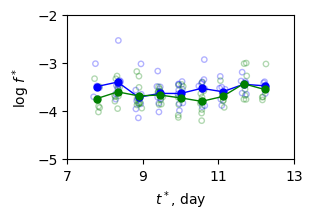

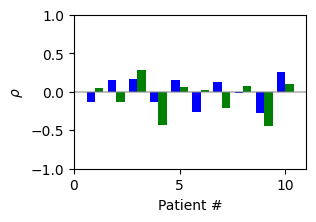

In [10]:
def binner(t,f,ed):
    y = np.zeros(len(ed)-1)
    for i in range(len(ed)-1):
        y[i] = np.mean([f[j] for j, x in enumerate(t) if x>= ed[i] and x<ed[i+1]])
    return y
plt.figure(figsize=(3,2))
ed = np.linspace(7.5,12.5,10)
xf = ed[1:] - 0.5*(ed[1]-ed[0])

m = xf[1]-xf[0]
b = xf[0]

r_all = []
for chain_type in ['alpha','beta']:
    if chain_type == 'alpha':
        chain_set = out_alpha_sorted
        qrplt = 'b'
        xDelt = -0.14
        lab = r'$\mathrm{\alpha}$'
        fs = fits[0][3]
        ts = fits[0][2]
    if chain_type == 'beta':
        chain_set = out_beta_sorted
        qrplt = 'g'
        xDelt = 0.14
        lab = r'$\mathrm{\beta}$'
        fs = fits[1][3]
        ts = fits[1][2]
    fB_all = []
    r_temp = []
    for i in range(len(fs)):
        t_temp = ts[i]
        f_temp = fs[i]
        fB = binner(t_temp,f_temp,ed)
        fB_all.append(fB)

        rho, pval = spearmanr(t_temp, f_temp)
        r_temp.append(rho)
    r_all.append(r_temp)
    # Prepare data grouped by index within inner lists
    values = []
    positions = []  # position inside inner list (0,1,2,...)
    for sublist in fB_all:
        for idx, val in enumerate(sublist):
            values.append(val)
            positions.append(idx)
    
    df = pd.DataFrame({'Position': positions, 'Value': values})
    
    # We will plot hollow scatter grouped by Position with manual jitter
    unique_pos = sorted(df['Position'].unique())
    color = 'tab:blue'
    size = 15  # smaller size for scatter
    
    for pos in unique_pos:
        y = df.loc[df['Position'] == pos, 'Value']
        # jitter x around pos
        x_jitter = np.random.uniform(-0.15, 0.15, size=len(y))
        x = np.full_like(y, pos) + x_jitter
        plt.scatter(x, y, facecolors='none', edgecolors=qrplt, s=size, linewidth=1, alpha=0.3)
    
    plt.xticks(unique_pos)
    plt.tight_layout()

    ymean = []
    for i in range(len(xf)):
        temp = [x[i] for x in fB_all]
        ymean.append(np.nanmean(temp))
    plt.plot(ymean,qrplt+'o-',linewidth=1,markersize=5)

plt.ylim([-5,-2])
plt.xlim([-0.3,len(xf)+0.3-1])
Q = [7,9,11,13]
plt.xticks((np.array(Q)-b)/m,Q);
plt.xlabel(r'$t^*$, day')
plt.ylabel(r'log $f^*$')
plt.savefig('figures/Fig_2a.svg') #########

plt.figure(figsize=(3,2))

N = len(r_all[0])
ind = np.arange(N)  # the x locations for the groups
width = 0.4        # width of the bars
plt.bar(ind + 1 - width/2, r_all[0], width, color='blue', label='x1');
plt.bar(ind + 1 + width/2, r_all[1], width, color='green', label='x2');

# plt.plot(np.array(list(range(13)))+1,r_all[0],'bo-')
# plt.plot(np.array(list(range(13)))+1,r_all[1],'go-')

# Labels & styling
plt.xlabel('Patient #')
plt.ylabel(r'$\rho$')
plt.xlim([0,11])
plt.xticks([0,5,10],[0,5,10]);
plt.ylim([-1,1])
# plt.yticks([-0.6,-0.3,0,0.3,0.6])
plt.plot([0,14],[0,0],color='gray',alpha=0.5)
plt.savefig('figures/Fig_2b.svg') #########

In [11]:
###############

In [12]:
# cross-match to single cell data
for chain_type in ['alpha', 'beta']:
    df = pd.read_csv('single_cell/VDJ_annotation_221129.csv')
    if chain_type == 'alpha':
        df = df[['patient_id','time_point','medium_annotation','IR_VJ_1_cdr3_tcr','IR_VJ_1_v_gene_tcr','nCount_RNA']]
        CDR3_aa = list(df['IR_VJ_1_cdr3_tcr'])
        V_gene = list(df['IR_VJ_1_v_gene_tcr'])
    if chain_type == 'beta':
        df = df[['patient_id','time_point','medium_annotation','IR_VDJ_1_cdr3_tcr','IR_VDJ_1_v_gene_tcr','nCount_RNA']]
        CDR3_aa = list(df['IR_VDJ_1_cdr3_tcr'])
        V_gene = list(df['IR_VDJ_1_v_gene_tcr'])
    ID_SC = list(df['patient_id'])
    D_sample = [int(x[1:]) for x in list(df['time_point'])]
    C_type = list(df['medium_annotation'])
    RNA_count = list(df['nCount_RNA'])
    # combine into vector
    SC_set = []
    for i, C in enumerate(C_type):
        if C[:5] == 'T CD4' or C[:5] == 'T CD8':
            SC_set.append((ID_SC[i],D_sample[i],C[:5],CDR3_aa[i], V_gene[i]))
    SC_set = list(set(SC_set))
    
    if chain_type == 'alpha':
        SC_set_alpha = SC_set.copy()
    if chain_type == 'beta':
        SC_set_beta = SC_set.copy()

print('alpha:')
matched_dset_alpha = []
matched_dset_clean_alpha = []
for i, x in enumerate(full_out[0]):
    ID = int(total_list_sorted[i])
    temp = []
    for y in x:
        CDR3 = y[1][0]
        Vg1 = y[1][1]
        Q = [z for z in SC_set_alpha if ID == z[0] and CDR3 == z[3] and Vg1 == z[4]]
        if len(Q) > 0:
            temp.append([Q,y[0]])
    if len(temp) > 0:
        print('ID: ' + str(ID) + '; N = ' + str(len(temp)))
        matched_dset_alpha.append([ID,temp])
print('beta:')
matched_dset_beta = []
matched_dset_clean_beta = []
for i, x in enumerate(full_out[1]):
    ID = int(total_list_sorted[i])
    temp = []
    for y in x:
        CDR3 = y[1][0]
        Vg1 = y[1][1]
        Q = [z for z in SC_set_beta if ID == z[0] and CDR3 == z[3] and Vg1 == z[4]]
        if len(Q) > 0:
            temp.append([Q,y[0]])
    if len(temp) > 0:
        print('ID: ' + str(ID) + '; N = ' + str(len(temp)))
        matched_dset_beta.append([ID,temp])

/var/folders/zm/c02xmwfx58l3xfx_hgwyrdgw0000gn/T/ipykernel_85944/1403899496.py:3: DtypeWarning: Columns (32,36,40,52,56,60,64,98) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('single_cell/VDJ_annotation_221129.csv')
/var/folders/zm/c02xmwfx58l3xfx_hgwyrdgw0000gn/T/ipykernel_85944/1403899496.py:3: DtypeWarning: Columns (32,36,40,52,56,60,64,98) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('single_cell/VDJ_annotation_221129.csv')


alpha:
ID: 635779; N = 19
ID: 673353; N = 41
ID: 674700; N = 14
beta:
ID: 635779; N = 13
ID: 673353; N = 61
ID: 674700; N = 13


In [13]:
RQ = [matched_dset_alpha,matched_dset_beta]
Ctype_all = []
Pset = []
for SRR in RQ:
    x1 = []
    x2 = []
    Ctype_t = []
    for q in SRR:
        Ctype = []
        Params = []
        for [x,y] in q[1]:
            # x is quant, y is param
            if len(list(set(x))) == 1:
                Ctype.append(int(x[0][2][4]))
                Params.append(y)
            if len(list(set(x))) > 1.5:
                s = [int(h[2][4]) for h in x]
                L4 = len([f for f in s if f == 4])
                L8 = len([f for f in s if f == 8])
                if L4 > L8:
                    Ctype.append(4)
                    Params.append(y)
                if L8 > L4:
                    Ctype.append(8)
                    Params.append(y)
        Ctype_t.append(Ctype)
        
        x1.extend([Params[i] for i, x in enumerate(Ctype) if x == 4])
        x2.extend([Params[i] for i, x in enumerate(Ctype) if x == 8])
    Pset.append([x1,x2])
    Ctype_all.append(Ctype_t)

alpha:
N_CD4+ = 27; N_CD8+ = 45
t_e: p = 0.22107480894828574
t_c: p = 0.475635335658226
t^*: p = 0.0003245538938052382
f^*: p = 0.08582002073853298
beta:
N_CD4+ = 26; N_CD8+ = 59
t_e: p = 0.060933249018387495
t_c: p = 0.001646698100183737
t^*: p = 3.750678687840268e-07
f^*: p = 0.05874185251954547


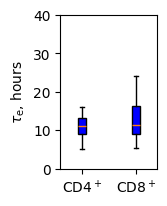

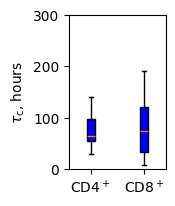

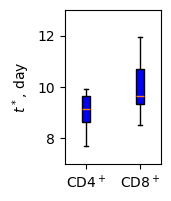

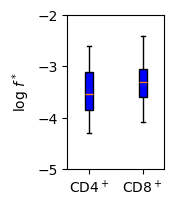

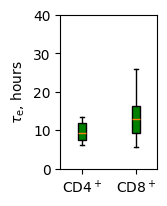

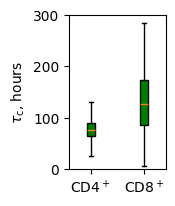

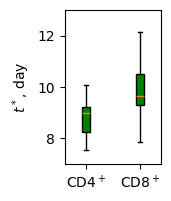

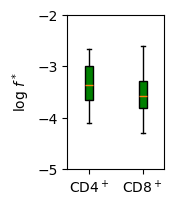

In [14]:
clr = ['b','g']
for ijk in [0,1]:
    qrplt = clr[ijk]
    if ijk == 0:
        print('alpha:')
    if ijk == 1:
        print('beta:')
    for irQ in range(4):    
        plt.figure(figsize=(1.25,2))
        x1 = [g[irQ] for g in Pset[ijk][0]]
        x2 = [g[irQ] for g in Pset[ijk][1]]
        if irQ == 0:
            x1 = [24*a for a in x1]
            x2 = [24*a for a in x2]
            
            q = stats.ttest_ind(x1,x2, equal_var=False)
            p = q.pvalue
            
            bplot = plt.boxplot([x1,x2],showfliers=False,patch_artist=True)
            for patch in bplot['boxes']:
                patch.set_facecolor(qrplt)
                
            plt.xlim([0.6,2.4])
            plt.ylim([0,40])
            plt.xticks([1,2],['CD4$^+$','CD8$^+$'])
            plt.ylabel(r'$\tau_\mathrm{e}$, hours')
            plt.savefig('figures/Fig_5a_' + str(ijk) + '.svg') #########
            
            print('N_CD4+ = ' + str(len(x1)) + '; N_CD8+ = ' + str(len(x2)))
            print('t_e: p = ' + str(p))
        if irQ == 1:
            x1 = [24*a for a in x1]
            x2 = [24*a for a in x2]
            
            q = stats.ttest_ind(x1,x2, equal_var=False)
            p = q.pvalue
            
            bplot = plt.boxplot([x1,x2],showfliers=False,patch_artist=True)
            for patch in bplot['boxes']:
                patch.set_facecolor(qrplt)
                
            plt.xlim([0.6,2.4])
            plt.ylim([0,300])
            plt.xticks([1,2],['CD4$^+$','CD8$^+$'])
            plt.ylabel(r'$\tau_\mathrm{c}$, hours')
            plt.savefig('figures/Fig_5b_' + str(ijk) + '.svg') #########
            
            print('t_c: p = ' + str(p))
        if irQ == 2:
            # U1, p = stats.mannwhitneyu(x1,x2)
            
            q = stats.ttest_ind(x1,x2, equal_var=False)
            p = q.pvalue
            
            bplot = plt.boxplot([x1,x2],showfliers=False,patch_artist=True)
            for patch in bplot['boxes']:
                patch.set_facecolor(qrplt)
                
            plt.xlim([0.6,2.4])
            plt.ylim([7,13])
            plt.xticks([1,2],['CD4$^+$','CD8$^+$'])
            plt.ylabel(r'$t^*$, day')
            plt.savefig('figures/Fig_5c_' + str(ijk) + '.svg') #########
            
            print('t^*: p = ' + str(p))
        if irQ == 3:
            # U1, p = stats.mannwhitneyu(x1,x2)
    
            q = stats.ttest_ind(x1,x2, equal_var=False)
            p = q.pvalue
            
            bplot = plt.boxplot([x1,x2],showfliers=False,patch_artist=True)
            for patch in bplot['boxes']:
                patch.set_facecolor(qrplt)
            plt.xlim([0.6,2.4])
            plt.ylim([-5,-2])
            plt.xticks([1,2],['CD4$^+$','CD8$^+$'])
            plt.ylabel(r'log $f^*$')

            plt.savefig('figures/Fig_5d_' + str(ijk) + '.svg') #########
            print('f^*: p = ' + str(p))


In [15]:
# coupled match

alpha:
[0.1627577, 1.1e-06, 0.0071352]
beta:
[0.0432941, 0.0029095, 0.0526776]


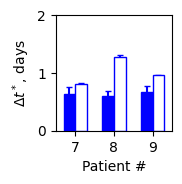

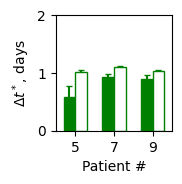

In [16]:
thr = 10
for chain_type in ['alpha','beta']:
    if chain_type == 'alpha':
        chain_set_sorted = full_out[0]
        qrplt = 'b'
        ccr = 0
    if chain_type == 'beta':
        chain_set_sorted = full_out[1]
        qrplt = 'g'
        ccr = 1
    Vcomp = []
    Jcomp = []
    VJcomp = []
    VJ_ID = []
    for i, temp_in in enumerate(chain_set_sorted):
        VJ_ID_mat = []
        VJ_ID_mismat = []
        V_mat_temp = []
        V_mismat_temp = []
        J_mat_temp = []
        J_mismat_temp = []
        VJ_mat_temp = []
        VJ_mismat_temp = []
        L = len(temp_in)
        for k1 in range(L-1):
            CD1 = temp_in[k1][1][0]
            Vgene1 = temp_in[k1][1][1]
            Jgene1 = temp_in[k1][1][2]
            ds1 = temp_in[k1][0][2]
            for k2 in range(k1+1,L):
                CD2 = temp_in[k2][1][0]
                Vgene2 = temp_in[k2][1][1]
                Jgene2 = temp_in[k2][1][2]
                ds2 = temp_in[k2][0][2]
                ####################################
                if Vgene1 == Vgene2:
                    V_mat_temp.append(np.abs(ds1-ds2))
                if Vgene1 != Vgene2:
                    V_mismat_temp.append(np.abs(ds1-ds2))
                if Jgene1 == Jgene2:
                    J_mat_temp.append(np.abs(ds1-ds2))
                if Jgene1 != Jgene2:
                    J_mismat_temp.append(np.abs(ds1-ds2))
                if Vgene1 == Vgene2 and Jgene1 == Jgene2:
                    VJ_mat_temp.append(np.abs(ds1-ds2))
                    VJ_ID_mat.append([CD1,CD2,Vgene1,Jgene1])
                if Vgene1 != Vgene2 and Jgene1 != Jgene2:
                    VJ_mismat_temp.append(np.abs(ds1-ds2))
                    VJ_ID_mismat.append([CD1,CD2,Vgene1,Jgene1])
        Vcomp.append([V_mat_temp, V_mismat_temp])
        Jcomp.append([J_mat_temp, J_mismat_temp])
        VJcomp.append([VJ_mat_temp, VJ_mismat_temp])
        VJ_ID.append([VJ_ID_mat, VJ_ID_mismat])
        
    ind = [i for i, x in enumerate(VJcomp) if len(x[0]) >= thr]
    set_in = [x for i, x in enumerate(VJcomp) if len(x[0]) >= thr]
    
    VJmat = []
    VJmismat = []
    for temp in set_in:
        x_mat = temp[0]
        x_mismat = temp[1]
        VJmat.append(np.mean(x_mat))
        VJmismat.append(np.mean(x_mismat))
        
    plt.figure(figsize=(1.5,1.5))
    plt.ylim([0,2])
    plt.yticks([0,1,2])
    plt.xlim([0.5,len(ind) + 0.5])
    plt.xticks(list(range(1,len(ind)+1)),ind)
    plt.xlabel('Patient #')
    plt.ylabel(r'$\Delta t^*$, days')
    cc = 0
    p_test=[]
    for i in ind:
        x_mat = VJcomp[i][0]
        x_mismat = VJcomp[i][1]
    
        U1, p = stats.mannwhitneyu(x_mat,x_mismat)
    
        q = stats.ttest_ind(x_mat,x_mismat, equal_var=False)
        p = q.pvalue
        
        p_test.append(p)
        
        plt.errorbar(cc+1-0.15,np.mean(x_mat),yerr = np.std(x_mat)/np.sqrt(len(x_mat)-1),capsize=2.5,fmt='',color=qrplt,zorder= 0)
        plt.errorbar(cc+1+0.15,np.mean(x_mismat),yerr = np.std(x_mismat)/np.sqrt(len(x_mismat)-1),capsize=2.5,fmt='',color=qrplt,zorder= 0)
        plt.bar(cc+1-0.15,np.mean(x_mat),color=qrplt, edgecolor=qrplt,width=0.3)
        plt.bar(cc+1+0.15,np.mean(x_mismat),color='w', edgecolor=qrplt,width=0.3)
        cc += 1
    
    print(chain_type + ':')
    print([np.round(10000000*x)/10000000 for x in p_test])
    plt.savefig('figures/Fig_4a_' + str(ccr) + '.svg') #########

In [17]:
# memory part

alpha: p_bar = 0.527455370823924
beta: p_bar = 0.5932450352994402


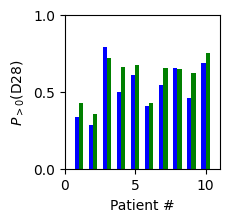

In [18]:
# Fend_all & R_all
La_p28 = [len([1 for y in x if y > -100])/len(x) for x in Fend_all[0]]
Lb_p28 = [len([1 for y in x if y > -100])/len(x) for x in Fend_all[1]]

print('alpha: p_bar = ' + str(np.mean(La_p28)))
print('beta: p_bar = ' + str(np.mean(Lb_p28)))

iRD = np.array(list(range(1,11)))
plt.figure(figsize=(2,2))
plt.bar(iRD-0.15,La_p28,color='b',width=0.3);
plt.bar(iRD+0.15,Lb_p28,color='g',width=0.3);
plt.ylim([0,1])
plt.yticks([0,0.5,1]);
plt.xlim([0,11])
plt.xticks([0,5,10]);
plt.xlabel('Patient #')
plt.ylabel(r'$P_{>0}$(D28)')
plt.savefig('figures/Fig_6a.svg') #########

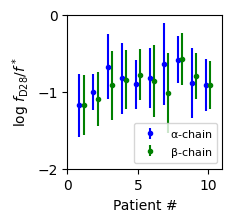

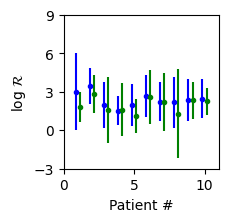

In [19]:
def plotter(X,mode):
    if mode == 0:
        xD = -0.15
        qrplt = 'b'
    if mode == 1:
        xD = 0.15
        qrplt = 'g'
    iRD = np.array(list(range(1,11)))
    r_m = []
    r_std = []
    for x in X:
        y = [z for z in x if z > -100]
        r_m.append(np.mean(y))
        r_std.append(np.std(y))

    plt.errorbar(iRD+xD,r_m,r_std,fmt = qrplt + '.',linewidth=1.5)

plt.figure(figsize=(2,2))
plt.xlim([0,11])
plt.xticks([0,5,10]);
plt.xlabel('Patient #')
plotter(Fend_all[0],0)
plotter(Fend_all[1],1)
plt.ylim([-2,0])
plt.ylabel(r'log $f_\mathrm{D28}/f^*$')
plt.yticks([-2,-1,0])
plt.legend([r'$\mathrm{\alpha}$-chain',r'$\mathrm{\beta}$-chain'],fontsize=8,loc='lower right')
plt.savefig('figures/Fig_6c.svg') #########


plt.figure(figsize=(2,2))
plt.xlim([0,11])
plt.xticks([0,5,10]);
plt.xlabel('Patient #')
plotter(R_all[0],0);
plotter(R_all[1],1);
plt.ylim([-3,9]);
plt.ylabel(r'log $\mathcal{R}$')
plt.yticks([-3,0,3,6,9]);
plt.savefig('figures/Fig_6d.svg') #########

alpha:
log f28/f*: p = 0.0373931253507898
log R: p = 0.03151817614332157
beta:
log f28/f*: p = 0.00026282764661859567
log R: p = 0.5780992561912993


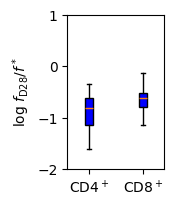

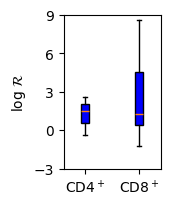

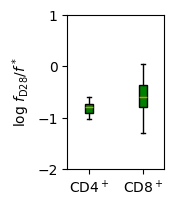

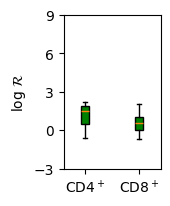

In [20]:
clr = ['b','g']
for ijk in [0,1]:
    qrplt = clr[ijk]
    if ijk == 0:
        print('alpha:')
    if ijk == 1:
        print('beta:')
    for irQ in [4,5]:    
        plt.figure(figsize=(1.25,2))
        x1 = [g[irQ] for g in Pset[ijk][0] if g[irQ]  > -100]
        x2 = [g[irQ] for g in Pset[ijk][1] if g[irQ] > -100]
        if irQ == 4:
            q = stats.ttest_ind(x1,x2, equal_var=False)
            p = q.pvalue
            
            bplot = plt.boxplot([x1,x2],showfliers=False,patch_artist=True)
            for patch in bplot['boxes']:
                patch.set_facecolor(qrplt)
                
            plt.xlim([0.6,2.4])
            plt.ylim([-2,1])
            plt.yticks([-2,-1,0,1])
            plt.xticks([1,2],['CD4$^+$','CD8$^+$'])
            plt.ylabel(r'log $f_\mathrm{D28}/f^*$')
            plt.savefig('figures/Fig_6e_' + str(ijk) + '.svg') #########
            print('log f28/f*: p = ' + str(p))
        if irQ == 5:
            q = stats.ttest_ind(x1,x2, equal_var=False)
            p = q.pvalue
            
            bplot = plt.boxplot([x1,x2],showfliers=False,patch_artist=True)
            for patch in bplot['boxes']:
                patch.set_facecolor(qrplt)
                
            plt.xlim([0.6,2.4])
            plt.ylim([-3,9])
            plt.yticks([-3,0,3,6,9])
            plt.xticks([1,2],['CD4$^+$','CD8$^+$'])
            plt.ylabel(r'log $\mathcal{R}$')
            plt.savefig('figures/Fig_6f_' + str(ijk) + '.svg') #########
            print('log R: p = ' + str(p))

$\alpha$:
log f28/f*: p = 0.0374
log R: p = 0.0315
$\beta$:
log f28/f*: p = 0.000263


/opt/homebrew/Cellar/jupyterlab/4.4.3/libexec/lib/python3.13/site-packages/seaborn/categorical.py:3399: UserWarning: 8.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/homebrew/Cellar/jupyterlab/4.4.3/libexec/lib/python3.13/site-packages/seaborn/categorical.py:3399: UserWarning: 10.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/homebrew/Cellar/jupyterlab/4.4.3/libexec/lib/python3.13/site-packages/seaborn/categorical.py:3399: UserWarning: 16.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/homebrew/Cellar/jupyterlab/4.4.3/libexec/lib/python3.13/site-packages/seaborn/categorical.py:3399: UserWarning: 14.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.

log R: p = 0.578


/opt/homebrew/Cellar/jupyterlab/4.4.3/libexec/lib/python3.13/site-packages/seaborn/categorical.py:3399: UserWarning: 8.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/homebrew/Cellar/jupyterlab/4.4.3/libexec/lib/python3.13/site-packages/seaborn/categorical.py:3399: UserWarning: 10.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/homebrew/Cellar/jupyterlab/4.4.3/libexec/lib/python3.13/site-packages/seaborn/categorical.py:3399: UserWarning: 16.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


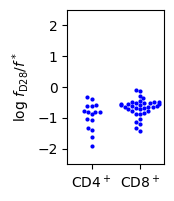

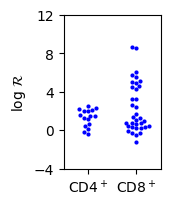

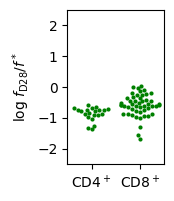

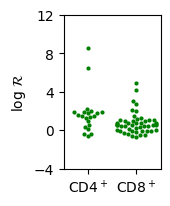

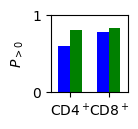

In [21]:
clr = ['b', 'g']
labels = ['CD4$^+$', 'CD8$^+$']
f_all = []
for ijk in [0, 1]:
    if ijk == 0:
        rd = -0.15
    if ijk == 1:
        rd = 0.15
        
    qrplt = clr[ijk]
    label = r'$\alpha$' if ijk == 0 else r'$\beta$'
    print(f'{label}:')

    f1 = len([g[irQ] for g in Pset[ijk][0] if g[irQ] > -100])/len([g[irQ] for g in Pset[ijk][0]])
    f2 = len([g[irQ] for g in Pset[ijk][1] if g[irQ] > -100])/len([g[irQ] for g in Pset[ijk][1]])
    f_all.append([f1,f2])
    
    for irQ in [4, 5]:
        # Extract data
        x1 = [g[irQ] for g in Pset[ijk][0] if g[irQ] > -100]
        x2 = [g[irQ] for g in Pset[ijk][1] if g[irQ] > -100]

        
        # Combine into dataframe
        df = pd.DataFrame({
            'Value': x1 + x2,
            'Subset': [labels[0]] * len(x1) + [labels[1]] * len(x2),
            'Chain': [label] * (len(x1) + len(x2))  # Optional, for legend
        })

        # Plot
        plt.figure(figsize=(1.25, 2))
        sns.swarmplot(data=df, x='Subset', y='Value', color=qrplt, size=3, alpha=1)

        # Stats
        p = stats.ttest_ind(x1, x2, equal_var=False).pvalue
        if irQ == 4:
            plt.ylim([-2.5, 2.5])
            plt.yticks([-2, -1,0,1,2])
            plt.ylabel(r'log $f_\mathrm{D28}/f^*$')
            print(f'log f28/f*: p = {p:.3g}')
            plt.savefig(f'figures/Fig_6e_{ijk}.svg')
        elif irQ == 5:
            plt.ylim([-4, 12])
            plt.yticks([-4, 0, 4, 8, 12])
            plt.ylabel(r'log $\mathcal{R}$')
            print(f'log R: p = {p:.3g}')
            plt.savefig(f'figures/Fig_6f_{ijk}.svg')

        plt.xlabel('')

plt.figure(figsize=(1,1))
plt.xlim([-0.5,1.5])
plt.xticks([0,1],[r'$\mathrm{CD4}^+$',r'$\mathrm{CD8}^+$'])
plt.ylabel(r'$P_{>0}$')
plt.ylim([0,1])
plt.yticks([0,1])
plt.bar([-0.15, 1 -0.15], [f_all[0][0],f_all[0][1]],color='b',width=0.3)
plt.bar([0.15, 1 + 0.15], [f_all[1][0],f_all[1][1]],color='g',width=0.3)
plt.savefig('figures/Fig_6e_inset.svg')

re: r^2 = 0.019538329395244077; p = 0.016845883862502603
rc: r^2 = 0.0562538202638305; p = 4.23813949597098e-05
t^*: r^2 = 0.0008158560418402202; p = 0.6269007187409555
f^*: r^2 = 0.1753614326209806; p = 7.94133069525053e-14
re: r^2 = 0.0003714253795944957; p = 0.734959806110646
rc: r^2 = 0.1052322667486171; p = 4.716498800882484e-09
t^*: r^2 = 0.01583193095850349; p = 0.02649772544503353
f^*: r^2 = 0.1709746022808475; p = 2.8336557542250927e-14


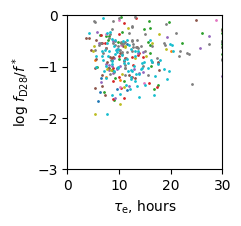

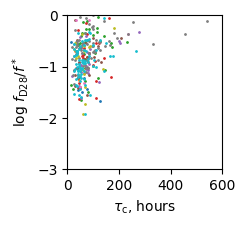

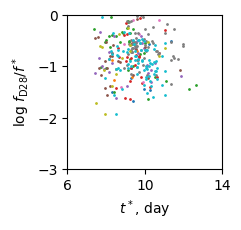

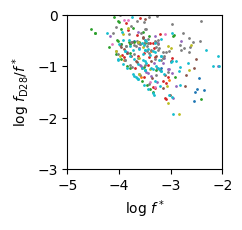

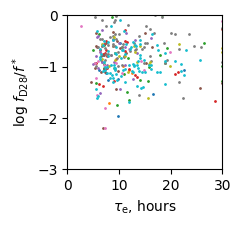

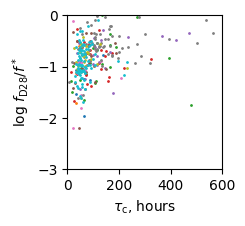

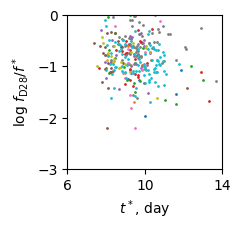

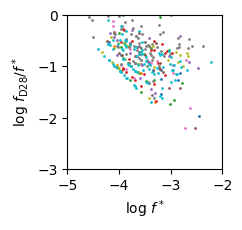

In [22]:
for ijk in [0,1]:
    tr_emp = full_out[ijk]
    x_all = []
    y_all = []
    plt.figure(figsize=(2,2))
    for i, z in enumerate(tr_emp):
        s = [24*y[0][0] for j, y in enumerate(z) if y[0][4] > -100]
        z = [y[0][4] for j, y in enumerate(z) if y[0][4] > -100]
        x_all.extend(s)
        y_all.extend(z)
        plt.plot(s,z,'.',markersize=2)
    plt.xlim([0,30])   
    plt.ylim([-3,0])
    plt.yticks([-3,-2,-1,0])
    r, p = stats.pearsonr(x_all, y_all)
    print('re: r^2 = ' + str(r**2) + '; p = ' + str(p))
    plt.xlabel(r'$\tau_\mathrm{e}$, hours')
    plt.ylabel(r'log $f_\mathrm{D28}/f^*$')
    plt.savefig(f'figures/SI_Fig_3a_{ijk}.svg')
    
    
    x_all = []
    y_all = []
    plt.figure(figsize=(2,2))
    for i, z in enumerate(tr_emp):
        s = [24*y[0][1] for j, y in enumerate(z) if y[0][4] > -100]
        z = [y[0][4] for j, y in enumerate(z) if y[0][4] > -100]
        x_all.extend(s)
        y_all.extend(z)
        plt.plot(s,z,'.',markersize=2)
    plt.xlim([0,600])   
    plt.ylim([-3,0])
    plt.yticks([-3,-2,-1,0])
    r, p = stats.pearsonr(x_all, y_all)
    print('rc: r^2 = ' + str(r**2) + '; p = ' + str(p))
    plt.xlabel(r'$\tau_\mathrm{c}$, hours')
    plt.ylabel(r'log $f_\mathrm{D28}/f^*$')
    plt.savefig(f'figures/SI_Fig_3b_{ijk}.svg')

    
    x_all = []
    y_all = []
    plt.figure(figsize=(2,2))
    for i, z in enumerate(tr_emp):
        s = [y[0][2] for j, y in enumerate(z) if y[0][4] > -100]
        z = [y[0][4] for j, y in enumerate(z) if y[0][4] > -100]
        x_all.extend(s)
        y_all.extend(z)
        plt.plot(s,z,'.',markersize=2)
    plt.xlim([6,14])
    plt.xticks([6,10,14])
    plt.ylim([-3,0])
    plt.yticks([-3,-2,-1,0])
    r, p = stats.pearsonr(x_all, y_all)
    print('t^*: r^2 = ' + str(r**2) + '; p = ' + str(p))
    plt.xlabel(r'$t^*$, day')
    plt.ylabel(r'log $f_\mathrm{D28}/f^*$')
    plt.savefig(f'figures/SI_Fig_3c_{ijk}.svg')
    
    x_all = []
    y_all = []
    plt.figure(figsize=(2,2))
    for i, z in enumerate(tr_emp):
        s = [y[0][3] for j, y in enumerate(z) if y[0][4] > -100]
        z = [y[0][4] for j, y in enumerate(z) if y[0][4] > -100]
        x_all.extend(s)
        y_all.extend(z)
        plt.plot(s,z,'.',markersize=2)
    plt.xlim([-5,-2])
    plt.ylim([-3,0])
    plt.yticks([-3,-2,-1,0])
    r, p = stats.pearsonr(x_all, y_all)
    print('f^*: r^2 = ' + str(r**2) + '; p = ' + str(p))
    plt.xlabel(r'log $f^*$')
    plt.ylabel(r'log $f_\mathrm{D28}/f^*$')
    plt.savefig(f'figures/SI_Fig_3d_{ijk}.svg')

re: r^2 = 0.23175724515840757; p = 2.4006568077592597e-18
rc: r^2 = 0.3496694040585311; p = 6.313513940925524e-29
t^*: r^2 = 0.16362714162898492; p = 6.369884305405526e-13
f^*: r^2 = 0.015445350999988481; p = 0.03376948494089633
re: r^2 = 0.13672339078607254; p = 1.6422804105112037e-11
rc: r^2 = 0.23511502721325797; p = 9.59710997305782e-20
t^*: r^2 = 0.09948877766041844; p = 1.3015403437868394e-08
f^*: r^2 = 0.011139434445145304; p = 0.06302988130451849


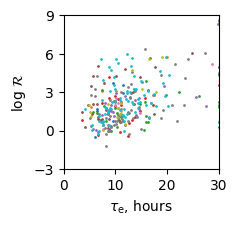

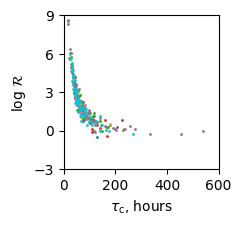

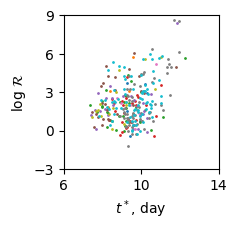

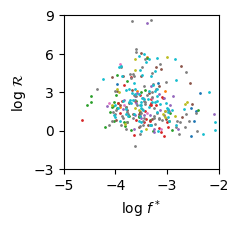

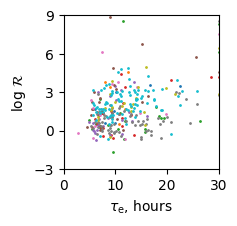

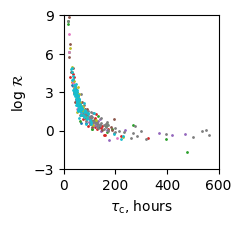

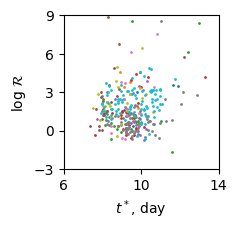

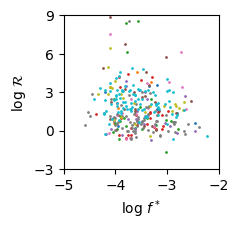

In [23]:
for ijk in [0,1]:
    tr_emp = full_out[ijk]
    x_all = []
    y_all = []
    plt.figure(figsize=(2,2))
    for i, z in enumerate(tr_emp):
        s = [24*y[0][0] for j, y in enumerate(z) if y[0][5] > -100]
        z = [y[0][5] for j, y in enumerate(z) if y[0][5] > -100]
        x_all.extend(s)
        y_all.extend(z)
        plt.plot(s,z,'.',markersize=2)
    plt.xlim([0,30])   
    plt.ylim([-3,9])
    plt.yticks([-3,0,3,6,9])
    r, p = stats.pearsonr(x_all, y_all)
    print('re: r^2 = ' + str(r**2) + '; p = ' + str(p))
    plt.xlabel(r'$\tau_\mathrm{e}$, hours')
    plt.ylabel(r'log $\mathcal{R}$')
    plt.savefig(f'figures/SI_Fig_3e_{ijk}.svg')
    
    
    x_all = []
    y_all = []
    plt.figure(figsize=(2,2))
    for i, z in enumerate(tr_emp):
        s = [24*y[0][1] for j, y in enumerate(z) if y[0][5] > -100]
        z = [y[0][5] for j, y in enumerate(z) if y[0][5] > -100]
        x_all.extend(s)
        y_all.extend(z)
        plt.plot(s,z,'.',markersize=2)
    plt.xlim([0,600])   
    plt.ylim([-3,9])
    plt.yticks([-3,0,3,6,9])
    r, p = stats.pearsonr(x_all, y_all)
    print('rc: r^2 = ' + str(r**2) + '; p = ' + str(p))
    plt.xlabel(r'$\tau_\mathrm{c}$, hours')
    plt.ylabel(r'log $\mathcal{R}$')
    plt.savefig(f'figures/SI_Fig_3f_{ijk}.svg')

    
    x_all = []
    y_all = []
    plt.figure(figsize=(2,2))
    for i, z in enumerate(tr_emp):
        s = [y[0][2] for j, y in enumerate(z) if y[0][5] > -100]
        z = [y[0][5] for j, y in enumerate(z) if y[0][5] > -100]
        x_all.extend(s)
        y_all.extend(z)
        plt.plot(s,z,'.',markersize=2)
    plt.xlim([6,14])
    plt.xticks([6,10,14])
    plt.ylim([-3,9])
    plt.yticks([-3,0,3,6,9])
    r, p = stats.pearsonr(x_all, y_all)
    print('t^*: r^2 = ' + str(r**2) + '; p = ' + str(p))
    plt.xlabel(r'$t^*$, day')
    plt.ylabel(r'log $\mathcal{R}$')
    plt.savefig(f'figures/SI_Fig_3g_{ijk}.svg')
    
    x_all = []
    y_all = []
    plt.figure(figsize=(2,2))
    for i, z in enumerate(tr_emp):
        s = [y[0][3] for j, y in enumerate(z) if y[0][5] > -100]
        z = [y[0][5] for j, y in enumerate(z) if y[0][5] > -100]
        x_all.extend(s)
        y_all.extend(z)
        plt.plot(s,z,'.',markersize=2)
    plt.xlim([-5,-2])
    plt.ylim([-3,9])
    plt.yticks([-3,0,3,6,9])
    r, p = stats.pearsonr(x_all, y_all)
    print('f^*: r^2 = ' + str(r**2) + '; p = ' + str(p))
    plt.xlabel(r'log $f^*$')
    plt.ylabel(r'log $\mathcal{R}$')
    plt.savefig(f'figures/SI_Fig_3h_{ijk}.svg')

alpha:
beta:
fraction CD4+ = 0.34


<Figure size 125x200 with 0 Axes>

<Figure size 125x200 with 0 Axes>

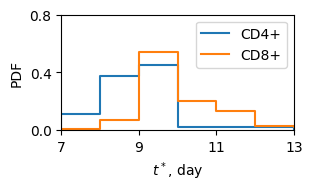

In [148]:
clr = ['b','g']
irQ = 2
x1_all = []
x2_all = []
for ijk in [0,1]:
    qrplt = clr[ijk]
    if ijk == 0:
        print('alpha:')
    if ijk == 1:
        print('beta:')    
    plt.figure(figsize=(1.25,2))
    x1 = [g[irQ] for g in Pset[ijk][0]]
    x2 = [g[irQ] for g in Pset[ijk][1]]
    x1_all.append(x1)
    x2_all.append(x2)
    
ed = np.linspace(7,14,8)
x = ed[1:] - 0.5*(ed[1]-ed[0])
f_CD4 = np.mean([(len(x1_all[0])/(len(x1_all[0]) + len(x2_all[0]))), (len(x1_all[1])/(len(x1_all[1]) + len(x2_all[1])))])

y1_CD4 = np.zeros(len(x))
for y in x1_all[0]:
    ind = [i for i in range(len(x)) if y >= ed[i] and y < ed[i+1]][0]
    y1_CD4[ind] = y1_CD4[ind] + 1 
y2_CD4 = np.zeros(len(x))
for y in x1_all[1]:
    ind = [i for i in range(len(x)) if y >= ed[i] and y < ed[i+1]][0]
    y2_CD4[ind] = y2_CD4[ind] + 1 
y_CD4 = y1_CD4 + y2_CD4
y_CD4 = y_CD4/sum(y_CD4)

y1_CD8 = np.zeros(len(x))
for y in x2_all[0]:
    ind = [i for i in range(len(x)) if y >= ed[i] and y < ed[i+1]][0]
    y1_CD8[ind] = y1_CD8[ind] + 1 
y2_CD8 = np.zeros(len(x))
for y in x2_all[1]:
    ind = [i for i in range(len(x)) if y >= ed[i] and y < ed[i+1]][0]
    y2_CD8[ind] = y2_CD8[ind] + 1 
y_CD8 = y1_CD8 + y2_CD8
y_CD8 = y_CD8/sum(y_CD8)

plt.figure(figsize=(3,1.5))
x_in = [6.5]; x_in.extend(list(x)); x_in.extend([14.5])
y_in = [0]; y_in.extend(list(y_CD4)); y_in.extend([0])
plt.step(x_in,y_in,where='mid')
y_in = [0]; y_in.extend(list(y_CD8)); y_in.extend([0])
plt.step(x_in,y_in,where='mid')
plt.ylim([0.,0.8])
plt.xlim([7,13])
plt.xticks([7,9,11,13])
plt.yticks([0,0.4,0.8])
plt.xlabel(r'$t^*$, day')
plt.ylabel('PDF')
print('fraction CD4+ = ' + str(round(f_CD4*1000)/1000))
plt.legend(['CD4+','CD8+'])  

plt.savefig('figures/tstar_distrib.svg')

/var/folders/zm/c02xmwfx58l3xfx_hgwyrdgw0000gn/T/ipykernel_85944/2358577365.py:101: RuntimeWarning: invalid value encountered in sqrt
  t_cross_beta_std = [np.std(x)/np.sqrt(len(x)-1)  for x in t48_beta]


[0, 0, 3, 0, 4, 4, 0, 0, 4, 4]
[2, 0, 4, 0, 2, 4, 4, 1, 4, 4]


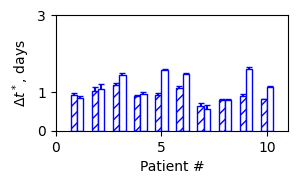

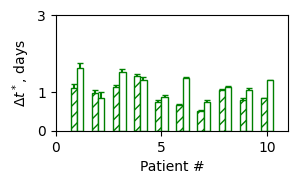

In [64]:
def ind_finder(z,ed):
    j = [i for i in range(len(ed)-1) if z >= ed[i] and z < ed[i+1]][0]
    C = [f_CD4*y_CD4[j], (1-f_CD4)*y_CD8[j]]
    w_CD4 = C[0]/sum(C)
    w_CD8 = C[0]/sum(C)
    CD4_flag = int(np.random.random() < w_CD4)
    if CD4_flag:
        Flag = 'CD4'
    if not CD4_flag:
        Flag = 'CD8'
    return Flag
def assigner(Rin):
    return [ind_finder(z,ed) for z in Rin]
def pair_finder(ts, ID):
    temp4 = [x for i, x in enumerate(ts) if ID[i] == 'CD4']
    temp8 = [x for i, x in enumerate(ts) if ID[i] == 'CD8']
    CD4_pair = []
    for i in range(len(temp4)-1):
        for j in range(i+1, len(temp4)):
            CD4_pair.extend([np.abs(temp4[i]-temp4[j])])
    CD8_pair = []
    for i in range(len(temp8)-1):
        for j in range(i+1, len(temp8)):
            CD8_pair.extend([np.abs(temp8[i]-temp8[j])])
    cross_pair = []
    for i in range(len(temp4)):
        for j in range(len(temp8)):
            cross_pair.extend([np.abs(temp4[i]-temp8[j])])
    return CD4_pair, CD8_pair, cross_pair

p_all_alpha = []
p_all_beta = []

d_star_alpha = []
for x in full_out[0]:
    temp = [z[0][2] for z in x]
    d_star_alpha.append(temp)
d_star_beta = []
for x in full_out[1]:
    temp = [z[0][2] for z in x]
    d_star_beta.append(temp)


p_alpha_tot = np.zeros(10)
p_bet_tot = np.zeros(10)
for r in range(100):
    alpha_ID = [assigner(z) for z in d_star_alpha]
    beta_ID = [assigner(z) for z in d_star_beta]
    alpha_Seq = [[q[1] for q in z] for z in out_alpha]
    beta_Seq = [[q[1] for q in z] for z in out_beta]
    
    t4_alpha = []
    t8_alpha = []
    t48_alpha = []
    for i in range(len(alpha_ID)):
        t4, t8, t48 = pair_finder(d_star_alpha[i], alpha_ID[i])
        t4_alpha.append(t4)
        t8_alpha.append(t8)
        t48_alpha.append(t48)
        
    t4_beta = []
    t8_beta = []
    t48_beta = []
    for i in range(len(beta_ID)):
        t4, t8, t48 = pair_finder(d_star_beta[i], beta_ID[i])
        t4_beta.append(t4)
        t8_beta.append(t8)
        t48_beta.append(t48)
    
    ird = list(range(10)); ird = np.array(ird) + 1
    t_all_alpha_mean = []
    t_all_alpha_std = []
    p_alpha = []
    for i in range(len(alpha_ID)):
        temp = []
        temp.extend(t4_alpha[i])
        temp.extend(t8_alpha[i])
        t_all_alpha_mean.extend([np.mean(temp)])
        t_all_alpha_std.extend([np.std(temp)/np.sqrt(len(temp)-1)])
    
        q = stats.ttest_ind(temp,t48_alpha[i], equal_var=False)
        p_alpha.append(q.pvalue)
        
    t_cross_alpha_mean = [np.mean(x) for x in t48_alpha]
    t_cross_alpha_std = [np.std(x)/np.sqrt(len(x)-1) for x in t48_alpha]
    
    t_all_beta_mean = []
    t_all_beta_std = []
    p_beta = []
    for i in range(len(beta_ID)):
        temp = []
        temp.extend(t4_beta[i])
        temp.extend(t8_beta[i])
        t_all_beta_mean.extend([np.mean(temp)])
        t_all_beta_std.extend([np.std(temp)/np.sqrt(len(temp)-1)])
    
        q = stats.ttest_ind(temp,t48_beta[i], equal_var=False)
        p_beta.append(q.pvalue)
    
    t_cross_beta_mean = [np.mean(x) for x in t48_beta]
    t_cross_beta_std = [np.std(x)/np.sqrt(len(x)-1)  for x in t48_beta]

    p_all_alpha.append(len([1 for x in p_alpha if x < 0.05]))
    p_all_beta.append(len([1 for x in p_beta if x < 0.05]))

    p_alpha_tot = p_alpha_tot+ np.array([int(x < 0.05) for x in p_alpha])
    p_beta_tot = p_beta_tot+ np.array([int(x < 0.05) for x in p_beta])

plt.figure(figsize=(3,1.5))
plt.bar(ird-0.15,t_all_alpha_mean,color = 'w', edgecolor='b',width=0.3,hatch='///');
plt.bar(ird+0.15,t_cross_alpha_mean,edgecolor='b',color='w',width=0.3);

plt.errorbar(ird-0.15,t_all_alpha_mean,yerr=t_all_alpha_std,capsize=2,fmt=' ',color='b',zorder=0)
plt.errorbar(ird+0.15,t_cross_alpha_mean,yerr=t_cross_alpha_std,capsize=2,fmt=' ',color='b',zorder=0)

plt.xlim([0,11])
plt.xticks([0,5,10])
plt.ylim([0,3])
plt.yticks([0,1,3])
plt.xlabel('Patient #')
plt.ylabel(r'$\Delta t^*$, days')

plt.savefig('figures/stat_check_alpha.svg')


plt.figure(figsize=(3,1.5))
plt.bar(ird-0.15,t_all_beta_mean,color = 'w',edgecolor='g',width=0.3,hatch='///');
plt.bar(ird+0.15,t_cross_beta_mean,edgecolor='g',color='w',width=0.3);

plt.errorbar(ird-0.15,t_all_beta_mean,yerr=t_all_beta_std,capsize=2,fmt=' ',color='g',zorder=0)
plt.errorbar(ird+0.15,t_cross_beta_mean,yerr=t_cross_beta_std,capsize=2,fmt=' ',color='g',zorder=0)

plt.xlim([0,11])
plt.xticks([0,5,10])
plt.ylim([0,3])
plt.yticks([0,1,3])
plt.xlabel('Patient #')
plt.ylabel(r'$\Delta t^*$, days')

plt.savefig('figures/stat_check_beta.svg')

flag_alpha = []
for x in p_alpha:
    temp = 0
    if x < 0.05:
        temp = 1
    if x < 0.01:
        temp = 2
    if x < 0.001:
        temp = 3
    if x < 0.0001:
        temp = 4
    flag_alpha.append(temp)

flag_beta = []
for x in p_beta:
    temp = 0
    if x < 0.05:
        temp = 1
    if x < 0.01:
        temp = 2
    if x < 0.001:
        temp = 3
    if x < 0.0001:
        temp = 4
    flag_beta.append(temp)

print(flag_alpha)
print(flag_beta)

In [65]:
print(np.mean(p_all_alpha))
print(np.mean(p_all_beta))

6.65
6.02


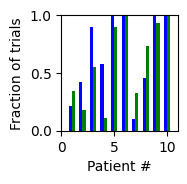

In [137]:
plt.figure(figsize=(1.5,1.5))
plt.bar(np.array(list(range(1,11)))-0.15,p_alpha_tot/100,color='b',width=0.3)
plt.bar(np.array(list(range(1,11)))+0.15,p_beta_tot/100,color='g',width=0.3)
plt.ylim([0,1])
plt.yticks([0,0.5,1])
plt.xlim([0,11])
plt.xticks([0,5,10])
plt.xlabel('Patient #')
plt.ylabel('Fraction of trials')

plt.savefig('figures/stat_check_cummel.svg')

# IDs: 16
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


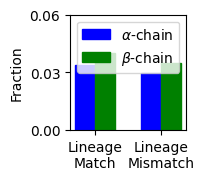

In [135]:
def compror(data):
    x = [z[0] for z in data]
    y = [z[1] for z in data]
    N = len(x)
    n_mat = 0
    n_mat_tot = 0
    n_mismat = 0
    n_mismat_tot = 0
    for i in range(N-1):
        L1 = x[i]
        V1 = y[i]
        for j in range(i+1,N):
            L2 = x[j]
            V2 = y[j]
            if L1 == L2:
                n_mat_tot += 1
                if V1 == V2:
                    n_mat += 1
            if L1 != L2 :
                n_mismat_tot += 1
                if V1 == V2:
                    n_mismat += 1
    return n_mat/n_mat_tot, n_mismat/n_mismat_tot
    
ID_SC = np.sort(list(set([x[0] for x in SC_set_alpha])))
print('# IDs: ' + str(len(ID_SC)))
V_alpha = []
for iid in ID_SC:
    temp = []
    for x in SC_set_alpha:
        if iid == x[0]:
            temp.append((x[2],x[4]))
    V_alpha.append(temp)
V_beta = []
for iid in ID_SC:
    temp = []
    for x in SC_set_beta:
        if iid == x[0]:
            temp.append((x[2],x[4]))
    V_beta.append(temp)

n_m_a = []
n_mm_a = []
for i, temp in enumerate(V_alpha):
    n1,n2 = compror(temp)
    n_m_a.append(n1)
    n_mm_a.append(n2)
n_m_b = []
n_mm_b = []
for i, temp in enumerate(V_beta):
    n1,n2 = compror(temp)
    n_m_b.append(n1)
    n_mm_b.append(n2)

############
Q_mat_a = [np.mean(n_m_a),np.std(n_m_a)]
Q_mismat_a = [np.mean(n_mm_a),np.std(n_mm_a)]

Q_mat_b = [np.mean(n_m_b),np.std(n_m_b)]
Q_mismat_b = [np.mean(n_mm_b),np.std(n_mm_b)]

plt.figure(figsize=(1.5,1.5))
plt.bar([0.85,1.85],[Q_mat_a[0],Q_mismat_a[0]],color='b',edgecolor='b',width = 0.3)
plt.bar([1.15,2.15],[Q_mat_b[0],Q_mismat_b[0]],color='g',edgecolor='g',width = 0.3)
plt.ylim([0,0.06])
plt.yticks([0,0.03,0.06])
plt.legend([r'$\alpha$-chain',r'$\beta$-chain'])
plt.xticks([1,2],['Lineage\nMatch','Lineage\nMismatch'])
plt.ylabel('Fraction of pairs')
plt.savefig('figures/stat_check_SC_match.svg')

In [149]:
print((Q_mat_a[0] - Q_mismat_a[0]))
print((Q_mat_b[0] - Q_mismat_b[0]))

0.0038280944923800957
0.00542860214588458
